In [59]:
import pandas as pd
import numpy as np
import instruments
import utils
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle



from collect_historical_data import run_hist_collection

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt



# Project Description

# Collecting Data
- Utilizing collect_historical_data.py that I created to fetch data utilizng the oanda_api.py OandaAPI class.
- Capturing Granularities of 5-Minutes, 1-Hour, 4-Hour candlesticks
- Collecting major currency pairs 
    - 'EUR_USD'
    - 'USD_JPY'
    - 'AUD_USD'
    - 'GBP_USD'
    - 'USD_CHF'
    - 'NZD_USD'

In [2]:
#Run Collect Historical data
start_date = "2014-01-01 00:00:00"
end_date = "2024-04-10 23:59:59"
pair_list = ['AUD_USD', 'EUR_USD', 'GBP_USD', 'NZD_USD', 'USD_CAD', 'USD_CHF', 'USD_JPY']

run_hist_collection(pair_list, start_date, end_date)

M5 AUD_USD
AUD_USD, M5, 2014-01-01 22:00:00+00:00, 2024-04-10 23:55:00+00:00
M5 EUR_USD
EUR_USD, M5, 2014-01-01 22:00:00+00:00, 2024-04-10 23:55:00+00:00
M5 GBP_USD
GBP_USD, M5, 2014-01-01 22:00:00+00:00, 2024-04-10 23:55:00+00:00
M5 NZD_USD
NZD_USD, M5, 2014-01-01 22:00:00+00:00, 2024-04-10 23:55:00+00:00
M5 USD_CAD
USD_CAD, M5, 2014-01-01 22:00:00+00:00, 2024-04-10 23:55:00+00:00
M5 USD_CHF
USD_CHF, M5, 2014-01-01 22:00:00+00:00, 2024-04-10 23:55:00+00:00
M5 USD_JPY
USD_JPY, M5, 2014-01-01 22:00:00+00:00, 2024-04-10 23:55:00+00:00
H1 AUD_USD
AUD_USD, H1, 2014-01-01 22:00:00+00:00, 2024-04-10 23:00:00+00:00
H1 EUR_USD
EUR_USD, H1, 2014-01-01 22:00:00+00:00, 2024-04-10 23:00:00+00:00
H1 GBP_USD
GBP_USD, H1, 2014-01-01 22:00:00+00:00, 2024-04-10 23:00:00+00:00
H1 NZD_USD
NZD_USD, H1, 2014-01-01 22:00:00+00:00, 2024-04-10 23:00:00+00:00
H1 USD_CAD
USD_CAD, H1, 2014-01-01 22:00:00+00:00, 2024-04-10 23:00:00+00:00
H1 USD_CHF
USD_CHF, H1, 2014-01-01 22:00:00+00:00, 2024-04-10 23:00:00+00:00

In [4]:
#load data from pickle using utils functions
for pairname in pair_list:
    print(pairname)

    H4_data = pd.read_pickle(utils.get_hist_data_filename(pairname, "H4"))

    print(H4_data.info())
    



AUD_USD
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15982 entries, 0 to 374
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype                  
---  ------  --------------  -----                  
 0   time    15982 non-null  datetime64[ns, tzutc()]
 1   volume  15982 non-null  int64                  
 2   mid_o   15982 non-null  float64                
 3   mid_h   15982 non-null  float64                
 4   mid_l   15982 non-null  float64                
 5   mid_c   15982 non-null  float64                
 6   bid_o   15982 non-null  float64                
 7   bid_h   15982 non-null  float64                
 8   bid_l   15982 non-null  float64                
 9   bid_c   15982 non-null  float64                
 10  ask_o   15982 non-null  float64                
 11  ask_h   15982 non-null  float64                
 12  ask_l   15982 non-null  float64                
 13  ask_c   15982 non-null  float64                
dtypes: datetime64[ns, tzutc()](1), f

# ETL 
The data is cleanned and processed from the **oanda_api script** and **collect_historical_data.py**. In there I am storing the api json response I am making to Oanda's API for the historical data. I then set it to only make 2000 calls each time but iterates/pages through the calls to achieve the total time range I needed.

Summary of ETL
- UTC datetime formatting for time values
- Float values for all price values
- Volume in full number - Int
- Stored as a Dataframe and then exported to Pickle to retain formatting done in these scripts


# PostGreSQL data pipeline
These are the functions to upload into my postgres data warehouse I setup for this project for a few reasons:
- Not continually having to call API and storing historical results since those don't change and are point in time data points
- Utilizing this data and future enrichments to this data in other ML or Algortihm trading projects 
- Organize each time frame into their own data table since 4 hour timeframe data is much less than the 5 minute timeframe 
    - Dont want to mix up the time frames because that would involve more sophisticated ETL but it is not necissarily needed for every application utilizing this data

In [5]:
### Code for SQL tables here

# EDA - Exploratory Data Analysis

In [26]:
# plot_columns = ['ENTRY', 'STOP_LOSS', 'TAKE_PROFIT']
# plot_colors = ['#043ef9','#eb5334', '#34eb37']

def plot_candles(df_plot, pair_name,granularity):
    fig = go.Figure()
    #add trace whenever dealing with bars or candles
    fig.add_trace(go.Candlestick(
        x = df_plot.time, open= df_plot.mid_o, high=df_plot.mid_h, low=df_plot.mid_l, close=df_plot.mid_c,
        line=dict(width=1), opacity=1,
        increasing_fillcolor='#24A06B',
        decreasing_fillcolor='#CC2E3C',
        increasing_line_color='#2EC886',
        decreasing_line_color='#FF3A4C'
    ))

    #Styling figure
    fig.update_layout(
        width=1400,height=500,
        margin=dict(l=10,r=10,b=10,t=10),
        font=dict(size=10, color='#e1e1e1'),
        paper_bgcolor='#1e1e1e',
        plot_bgcolor='#1e1e1e',
        title={
            'text': f'Candlestick - {pair_name}_{granularity}',
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )
    
    fig.update_xaxes(
        gridcolor='#1f292f',
        showgrid=True,
        fixedrange=True,
        rangeslider=dict(visible=False),
        rangebreaks=[
            dict(bounds=['sat', 'mon']) #remove the gaps from the weekends
        ]
    )
    fig.update_yaxes(
        gridcolor='#1f292f',
        showgrid=True
    )
    fig.show()

In [31]:
def plot_candles(fig, df_plot, pair_name, granularity, row, col):
    # Add Candlestick trace
    fig.add_trace(
        go.Candlestick(
            x=df_plot.time, 
            open=df_plot.mid_o, 
            high=df_plot.mid_h, 
            low=df_plot.mid_l, 
            close=df_plot.mid_c,
            line=dict(width=1), opacity=1,
            increasing_fillcolor='#24A06B',
            decreasing_fillcolor='#CC2E3C',
            increasing_line_color='#2EC886',
            decreasing_line_color='#FF3A4C'
        ),
        row=row, col=col
    )

    # Update axes and layout for this subplot
    fig.update_xaxes(
        title_text=f'{pair_name} {granularity}',
        gridcolor='#1f292f',
        showgrid=True,
        fixedrange=True,
        rangeslider=dict(visible=False),
        rangebreaks=[dict(bounds=['sat', 'mon'])],  # remove weekend gaps
        row=row, col=col
    )
    fig.update_yaxes(gridcolor='#1f292f', showgrid=True, row=row, col=col)


granularities = ["M5", "H1", 'H4']
for pair in pair_list:
    # Create a subplot figure with 1 row and 3 columns
    fig = make_subplots(rows=1, cols=3, subplot_titles=[f'{pair} {gran}' for gran in granularities])

    # Read and plot data for each granularity
    for i, granularity in enumerate(granularities, 1):
        df = pd.read_pickle(utils.get_hist_data_filename(pair, granularity))
        df_plot = df.iloc[:250]  # Select data to plot
        plot_candles(fig, df_plot, pair, granularity, 1, i)

    # Update overall figure layout
    fig.update_layout(
        width=1400,
        height=500,
        margin=dict(l=10, r=10, b=10, t=30),
        font=dict(size=10, color='#e1e1e1'),
        paper_bgcolor='#1e1e1e',
        plot_bgcolor='#1e1e1e',
        showlegend=False,
        title_text=f'Candlestick Charts for {pair}'
    )

    fig.show()

In [32]:
#Read in 4 Hour Candlesticks for each pair
granularities = ["M5","H1",'H4']
for granularity in granularities:
    for pair in pair_list: #4 Hour Granularity of data from 2014-2024
        print(pair,granularity)
        df = pd.read_pickle(utils.get_hist_data_filename(pair,granularity))
        print(df.info())
 


AUD_USD M5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 761382 entries, 0 to 863
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype                  
---  ------  --------------   -----                  
 0   time    761382 non-null  datetime64[ns, tzutc()]
 1   volume  761382 non-null  int64                  
 2   mid_o   761382 non-null  float64                
 3   mid_h   761382 non-null  float64                
 4   mid_l   761382 non-null  float64                
 5   mid_c   761382 non-null  float64                
 6   bid_o   761382 non-null  float64                
 7   bid_h   761382 non-null  float64                
 8   bid_l   761382 non-null  float64                
 9   bid_c   761382 non-null  float64                
 10  ask_o   761382 non-null  float64                
 11  ask_h   761382 non-null  float64                
 12  ask_l   761382 non-null  float64                
 13  ask_c   761382 non-null  float64                
dtypes: datetime6

# EDA inital results
- As expected with the different time frames there is more data in the 5 minute candlesticks for each pairs and followed by H1 and then H4 with the least values.
    - Need to consider this when looking across multiple timespans. 
- Utilize this in algorithms where a more miniscule scope is needed then drill into smaller time frames and to understand larger macro trends then use the larger time frames

# Basic ARIMA Model
For this dataset, I will utilize the random forest machine learning model to get a baseline understanding/ prediction of closing price based on the time-series dataset itself. 

In [40]:

# Dictionary to hold dataframes
forex_data = {}

# Loop to load data
for granularity in granularities:
    for pair in pair_list:
        print(pair, granularity)
        df = pd.read_pickle(utils.get_hist_data_filename(pair, granularity))
        df = df[['time', 'volume', 'mid_c']]
        key = f"{pair}_{granularity}"
        forex_data[key] = df

# Function to prepare data
def prepare_data(df, target='mid_c'):
    df['target'] = df[target].shift(-1)
    df = df.dropna()  # Drop rows with NaN values
    X = df.drop('target', axis=1)
    y = df['target']
    return X, y


AUD_USD M5
EUR_USD M5
GBP_USD M5
NZD_USD M5
USD_CAD M5
USD_CHF M5
USD_JPY M5
AUD_USD H1
EUR_USD H1
GBP_USD H1
NZD_USD H1
USD_CAD H1
USD_CHF H1
USD_JPY H1
AUD_USD H4
EUR_USD H4
GBP_USD H4
NZD_USD H4
USD_CAD H4
USD_CHF H4
USD_JPY H4


In [41]:
forex_data

{'AUD_USD_M5':                          time  volume    mid_c
 0   2014-01-01 22:00:00+00:00     119  0.88883
 1   2014-01-01 22:05:00+00:00     125  0.88914
 2   2014-01-01 22:10:00+00:00     164  0.88898
 3   2014-01-01 22:15:00+00:00      54  0.88932
 4   2014-01-01 22:20:00+00:00      51  0.88902
 ..                        ...     ...      ...
 859 2024-04-10 23:35:00+00:00      54  0.65119
 860 2024-04-10 23:40:00+00:00      48  0.65110
 861 2024-04-10 23:45:00+00:00      34  0.65112
 862 2024-04-10 23:50:00+00:00     153  0.65077
 863 2024-04-10 23:55:00+00:00     146  0.65074
 
 [761382 rows x 3 columns],
 'EUR_USD_M5':                          time  volume    mid_c
 0   2014-01-01 22:00:00+00:00      93  1.37598
 1   2014-01-01 22:05:00+00:00      49  1.37611
 2   2014-01-01 22:10:00+00:00     399  1.37498
 3   2014-01-01 22:15:00+00:00     117  1.37562
 4   2014-01-01 22:20:00+00:00     107  1.37628
 ..                        ...     ...      ...
 859 2024-04-10 23:35:00+00:00

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Model fitted for AUD_USD_M5


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Model fitted for EUR_USD_M5


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Model fitted for GBP_USD_M5


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Model fitted for NZD_USD_M5


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Model fitted for USD_CAD_M5


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Model fitted for USD_CHF_M5


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Model fitted for USD_JPY_M5


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Model fitted for AUD_USD_H1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters

Model fitted for EUR_USD_H1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Model fitted for GBP_USD_H1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Model fitted for NZD_USD_H1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Model fitted for USD_CAD_H1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Model fitted for USD_CHF_H1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Model fitted for USD_JPY_H1


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters

Model fitted for AUD_USD_H4


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Model fitted for EUR_USD_H4
Model fitted for GBP_USD_H4


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters

Model fitted for NZD_USD_H4
Model fitted for USD_CAD_H4


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency i

Model fitted for USD_CHF_H4
Model fitted for USD_JPY_H4
761382    0.650745
761383    0.650746
761384    0.650746
761385    0.650746
761386    0.650746
Name: predicted_mean, dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



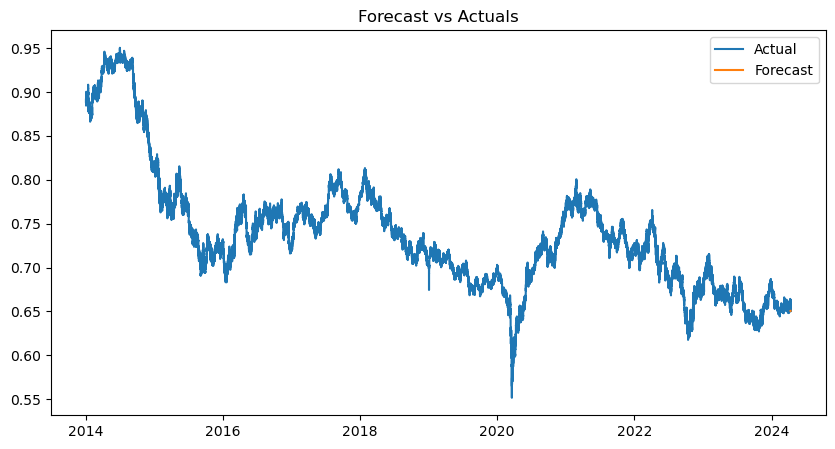

In [42]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming `forex_data` is your dictionary with currency pair labels as keys and dataframes as values
# Example: forex_data = {'AUD_USD_M5': DataFrame, 'EUR_USD_M5': DataFrame, ...}

# Function to check stationarity, differentiate if necessary, and fit ARIMA
def fit_arima(series, order):
    # Fit the ARIMA model
    model = ARIMA(series, order=order)
    fitted_model = model.fit()
    return fitted_model

# Dictionary to store models
arima_models = {}

# Process each currency pair
for pair, df in forex_data.items():
    # Assume 'mid_c' is your target variable and 'time' is the index
    df.set_index('time', inplace=True)
    # Checking for stationarity and determining differencing order might be needed here
    # For simplicity, we're assuming we've already determined order; let's say it's (1,1,1)
    fitted_model = fit_arima(df['mid_c'], (1,1,1))
    arima_models[pair] = fitted_model
    print(f"Model fitted for {pair}")

# Example to forecast the next 5 points for 'AUD_USD_M5'
forecast = arima_models['AUD_USD_M5'].forecast(steps=5)
print(forecast)



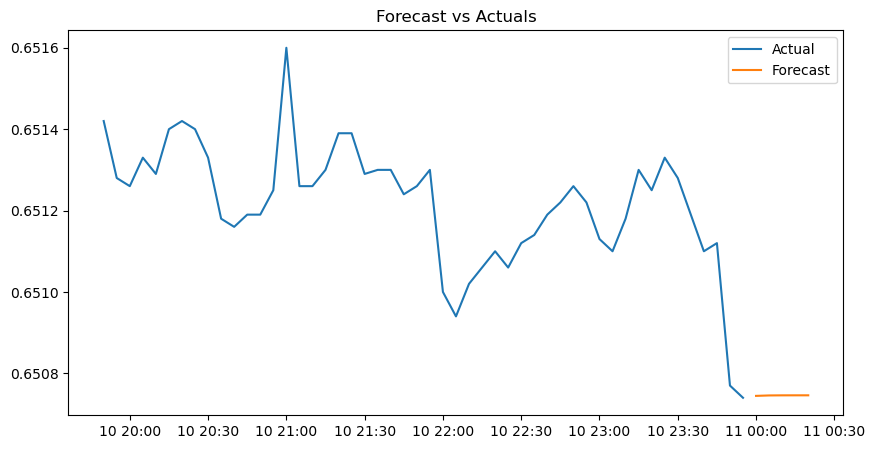

761382    0.650745
761383    0.650746
761384    0.650746
761385    0.650746
761386    0.650746
Name: predicted_mean, dtype: float64

In [46]:

# Plot the forecast against the actual data
plt.figure(figsize=(10, 5))
plt.plot(forex_data['AUD_USD_M5']['mid_c'][-50:], label='Actual')
forecast_index = pd.date_range(start=forex_data['AUD_USD_M5'].index[-1], periods=6, freq='5min')[1:]
plt.plot(forecast_index, forecast, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

forecast

# Logistic Regression Model

- I want to predict the trend/ position I should take given the Logisitic regression model. 1 = Buy; Sell = 0

In [56]:
def calculate_rsi(data, window=14):
    delta = data['mid_c'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [63]:
models = {}

for pair in pair_list:
    hour_data = pd.read_pickle(utils.get_hist_data_filename(pair, "H1"))

    #Feature Engineering - Creating indicators for the model to use in its learning and training 
    hour_data['returns'] = hour_data['mid_c'].pct_change()
    hour_data['moving_average_60'] = hour_data['mid_c'].rolling(window=50).mean()
    hour_data['volatility'] = hour_data['returns'].rolling(window=10).std()
    #Relative Strength index
    hour_data['RSI'] = calculate_rsi(hour_data)

    hour_data.dropna(inplace=True)


    #Target Variable 
    hour_data['Target'] = np.where(hour_data['mid_c'].shift(-3) > hour_data['mid_c'],1,0)


    x = hour_data[['volume','returns','volatility', 'moving_average_60', 'RSI']]
    y = hour_data['Target']



    #Split Data
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=16)


    logistic_regression_model = LogisticRegression()

    parameter_grid = {
        'C': [0.01, 0.1, 1, 10],
        'solver' : ['liblinear', 'saga'],
        'penalty' : ['l1','l2']
    }

    grid_search = GridSearchCV(logistic_regression_model, parameter_grid, cv=5, scoring='accuracy', verbose=1)
    #Fit Data to the model
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    #Predictions and Performance
    predictions = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    #save model and predictions
    with open(f'model_results/{pair}_mod_pred.pkl', 'wb') as f:
        pickle.dump({
            'model' : best_model,
            'predicitons' : predictions,
            'accuracy' : accuracy,
            'report': classification_report(y_test, predictions, output_dict=True)
        }, f)
    
    models[pair] = {
        'accuracy' :accuracy,
        'filename' : f'model_results/{pair}_mod_pred.pkl'
    }

print(models)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/pyt

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/pyt

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/pyt

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/pyt

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/pyt

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/pyt

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/opt/anaconda3/lib/pyt

{'AUD_USD': {'accuracy': 0.5155858395989975, 'filename': 'AUD_USD_mod_pred.pkl'}, 'EUR_USD': {'accuracy': 0.5218889498002975, 'filename': 'EUR_USD_mod_pred.pkl'}, 'GBP_USD': {'accuracy': 0.5163664839467502, 'filename': 'GBP_USD_mod_pred.pkl'}, 'NZD_USD': {'accuracy': 0.5165205136235516, 'filename': 'NZD_USD_mod_pred.pkl'}, 'USD_CAD': {'accuracy': 0.5165179270392986, 'filename': 'USD_CAD_mod_pred.pkl'}, 'USD_CHF': {'accuracy': 0.525293657008614, 'filename': 'USD_CHF_mod_pred.pkl'}, 'USD_JPY': {'accuracy': 0.5230974005637332, 'filename': 'USD_JPY_mod_pred.pkl'}}


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

